In [65]:
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [66]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [67]:
train_features = pd.read_csv('data/train_features.csv')
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv')

test_features = pd.read_csv('data/test_features.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [68]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [69]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [70]:
train_targets_scored.sum()[1:].sort_values()

atp-sensitive_potassium_channel_antagonist      1
erbb2_inhibitor                                 1
diuretic                                        6
autotaxin_inhibitor                             6
protein_phosphatase_inhibitor                   6
                                             ... 
serotonin_receptor_antagonist                 404
dopamine_receptor_antagonist                  424
cyclooxygenase_inhibitor                      435
proteasome_inhibitor                          726
nfkb_inhibitor                                832
Length: 206, dtype: object

In [71]:
train_features['cp_type'].unique()

array(['trt_cp', 'ctl_vehicle'], dtype=object)

(27796, 772)


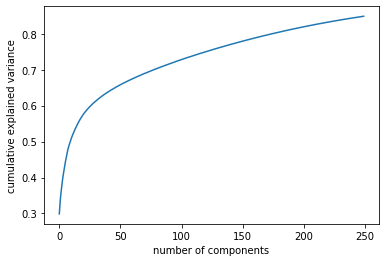

In [72]:
n_comp = 250

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
print(data.shape)
pca = (PCA(n_components=n_comp, random_state=42).fit(data[GENES]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [73]:
%%time
# GENES
n_comp = 100

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

CPU times: user 10 s, sys: 6.06 s, total: 16.1 s
Wall time: 1.35 s


(27796, 100)


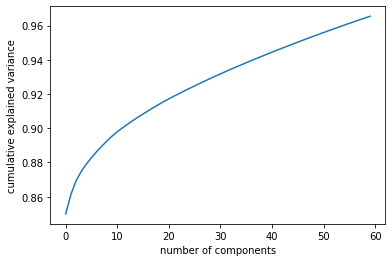

In [74]:
n_comp = 60

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
print(data.shape)
pca = (PCA(n_components=n_comp, random_state=42).fit(data[CELLS]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [75]:
%%time
#CELLS
n_comp = 15

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

CPU times: user 724 ms, sys: 1.27 s, total: 1.99 s
Wall time: 160 ms


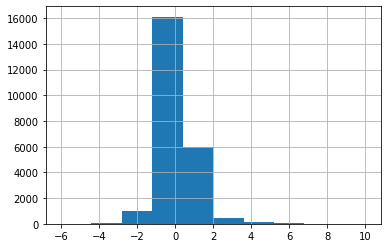

In [81]:
train_features['g-3'].hist()

In [82]:
train_features.columns

Index(['sig_id', 'cp_type', 'cp_time', 'cp_dose', 'g-0', 'g-1', 'g-2', 'g-3',
       'g-4', 'g-5',
       ...
       'pca_C-5', 'pca_C-6', 'pca_C-7', 'pca_C-8', 'pca_C-9', 'pca_C-10',
       'pca_C-11', 'pca_C-12', 'pca_C-13', 'pca_C-14'],
      dtype='object', length=991)

In [84]:
train_features[GENES].describe()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,0.119905,...,0.207299,0.009161,0.171027,0.002316,-0.209799,-0.076251,0.134162,-0.128018,-0.219210,0.101524
std,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,1.087180,...,1.096488,1.200395,1.357701,1.052771,1.201918,1.115477,0.951264,1.230636,1.326193,1.417674
min,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,...,-8.193000,-10.000000,-9.795000,-8.180000,-10.000000,-10.000000,-4.269000,-10.000000,-10.000000,-10.000000
25%,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,-0.360200,...,-0.433875,-0.502250,-0.537075,-0.508775,-0.606175,-0.506200,-0.353100,-0.544600,-0.554400,-0.523800
50%,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,0.160450,...,0.059600,-0.005900,-0.013600,-0.027700,-0.011850,0.009900,0.005400,0.000600,0.028700,-0.006500
75%,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,0.697775,...,0.648500,0.492150,0.522500,0.457000,0.483000,0.511175,0.409075,0.498500,0.496400,0.536950
max,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,6.433000,...,10.000000,9.552000,10.000000,8.346000,5.444000,6.317000,10.000000,5.911000,10.000000,10.000000


In [85]:
train_features._get_numeric_data()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
0,24,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,...,-0.450285,-0.176778,-1.262943,0.219107,-0.890670,0.393604,-0.703376,-0.615139,0.174407,0.082941
1,72,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,...,0.063234,0.658824,0.429385,-0.226422,0.271831,0.863835,0.003597,0.669397,0.447651,1.207365
2,48,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,...,-0.115802,0.726273,-0.212644,-0.902482,-0.118799,-0.336548,0.015536,0.572233,-0.261651,-0.638141
3,48,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,...,0.590366,0.698760,0.050321,-0.793301,0.295411,0.147857,0.056161,0.689218,-1.433683,1.323147
4,72,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,...,-0.000223,-0.287454,-0.110246,-0.105291,-0.396913,0.090983,-0.211590,0.350304,-0.326626,-0.344389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,24,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,...,-0.492270,0.802396,0.332499,-0.204876,0.238577,-0.483204,0.585078,0.173586,-0.611718,1.607084
23810,24,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,...,-1.364079,-0.375444,-1.433534,-0.858483,1.072457,0.101450,0.435098,-0.219500,0.377156,0.555680
23811,48,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,0.1745,-0.0340,...,-0.511130,-0.035609,-0.310135,-0.166686,-0.458886,-0.003948,0.292592,0.331622,-0.006669,0.081750
23812,24,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,0.4299,...,-1.129357,0.020524,-0.043233,-0.440007,0.302835,0.776086,-1.737516,-0.531532,-0.351892,0.542268


In [87]:
train_features.range()

AttributeError: 'DataFrame' object has no attribute 'range'

In [76]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,3972,3973,3974,3975,3976,3977,3978,3979,3980,3981
c-0,-0.0600,0.0927,-0.1312,-0.3998,-0.3774,0.0877,0.3467,1.6360,-0.9646,-0.9629,...,0.1481,-0.2805,0.3196,-0.2049,0.4931,-0.1993,0.1407,0.2594,-0.6305,-0.2457
c-1,0.1083,0.2723,-1.4640,-4.5520,0.7364,1.0270,0.2555,1.1480,-0.0619,-1.1560,...,0.3085,-0.5374,0.2696,-0.5181,0.5948,-0.7662,0.5437,0.0530,-0.2459,-0.3490
c-2,0.6864,0.2772,0.3394,-2.7350,-0.1659,0.4862,-0.4382,0.2302,-0.7304,-0.5949,...,0.6901,0.3796,-0.5206,-0.8884,1.1720,-0.9564,0.4300,0.3822,0.7818,0.2184
c-3,0.4043,0.7776,-1.7790,-1.9630,0.2341,0.7869,-0.1401,0.7595,0.5345,0.3754,...,0.1923,0.3994,-0.1457,-1.3030,0.2584,-0.3422,1.1630,0.4083,0.3728,0.5001
c-4,0.4213,0.3679,0.2188,-2.8610,1.0060,0.7077,0.8019,0.2395,-0.6229,-0.6140,...,0.0397,-0.2672,0.4676,-0.2577,1.1650,-0.4529,-0.0122,0.9142,0.0080,0.7936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c-95,0.6584,0.4899,-0.3174,-1.2880,-0.3031,0.4519,1.5880,1.4250,-1.3070,-1.1160,...,-1.2940,-0.3230,-0.4697,-0.1316,-0.0933,-0.4791,1.2730,0.4666,0.1286,-0.4041
c-96,-0.3981,0.1522,-0.6417,-1.6210,0.1094,1.2120,2.4670,0.6633,-0.1167,-0.8745,...,1.7880,-0.0991,0.3694,-0.0709,0.3248,-1.2680,0.2614,0.0461,-0.2618,-0.4948
c-97,0.2139,0.1241,-0.2187,-0.8784,0.2885,0.3765,0.0357,0.4562,-0.1241,-0.2716,...,-0.5257,0.4412,0.3465,-0.7379,-0.0608,-1.1280,-0.2790,0.5888,0.5074,0.0757
c-98,0.3801,0.6077,-1.4080,-0.3876,-0.3786,0.7848,0.1351,-0.9622,-0.6420,0.0189,...,0.6184,-0.7511,-1.0710,-0.2062,0.2712,-0.4167,-0.0131,-0.4205,0.7430,-0.1356


In [12]:
from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(threshold=0.5)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features


,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,...,967,968,969,970,971,972,973,974,975,976
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.450285,-0.176778,-1.262943,0.219107,-0.890670,0.393604,-0.703376,-0.615139,0.174407,0.082941
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.063234,0.658824,0.429385,-0.226422,0.271831,0.863835,0.003597,0.669397,0.447651,1.207365
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.115802,0.726273,-0.212644,-0.902482,-0.118799,-0.336548,0.015536,0.572233,-0.261651,-0.638141
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0.590366,0.698760,0.050321,-0.793301,0.295411,0.147857,0.056161,0.689218,-1.433683,1.323147
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,-0.000223,-0.287454,-0.110246,-0.105291,-0.396913,0.090983,-0.211590,0.350304,-0.326626,-0.344389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,-0.492270,0.802396,0.332499,-0.204876,0.238577,-0.483204,0.585078,0.173586,-0.611718,1.607084
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,-1.364079,-0.375444,-1.433534,-0.858483,1.072457,0.101450,0.435098,-0.219500,0.377156,0.555680
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,-0.511130,-0.035609,-0.310135,-0.166686,-0.458886,-0.003948,0.292592,0.331622,-0.006669,0.081750
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-1.129357,0.020524,-0.043233,-0.440007,0.302835,0.776086,-1.737516,-0.531532,-0.351892,0.542268


In [13]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [14]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [15]:
train

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,...,0,0,0,0,0,0,0,0,0,0
21945,id_fffb70c0c,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Binning

# for col in GENES:
#     train.loc[:, f'{col}_bin'] = pd.cut(train[col], bins=3, labels=False)
#     test.loc[:, f'{col}_bin'] = pd.cut(test[col], bins=3, labels=False)

In [17]:
# Distribution plots

# plt.figure(figsize=(16,16))
# sns.set_style("whitegrid")

# gene_choice = np.random.choice(len(GENES), 16)
# for i, col in enumerate(gene_choice):
#     plt.subplot(4, 4, i+1)
#     plt.hist(train_features.loc[:, GENES[col]],bins=100, color='orange')
#     plt.title(GENES[col])

In [18]:
# train_ = train.copy() [Didn't wanted to actually normalize, so created a copy and normalized that for further calculation]
# for col in GENES:
    
# #     train_[col] = (train[col]-np.mean(train[col])) / (np.std(train[col]))
    
#     mean = train_[col].mean()
#     std = train_[col].std()

#     std_r = mean + 4*std
#     std_l = mean - 4*std

#     drop = train_[col][(train_[col]>std_r) | (train_[col]<std_l)].index.values

# train = train.drop(drop).reset_index(drop=True)
# # folds = folds.drop(drop).reset_index(drop=True)
# target = target.drop(drop).reset_index(drop=True)

In [19]:
# n_comp = 50

# data = pd.concat([pd.DataFrame(train[CELLS]), pd.DataFrame(test[CELLS])])
# data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
# train2 = data2[:train.shape[0]]; test2 = data2[train.shape[0]:]

# train2 = pd.DataFrame(train2, columns=[f'c-{i}' for i in range(n_comp)])
# test2 = pd.DataFrame(test2, columns=[f'c-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
# train = train.drop(columns=drop_cols)
# test = test.drop(columns=drop_cols)

In [20]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

In [21]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=5)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,0,0,0,0,0,0,0,0,0,1
3,id_0015fd391,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,0,0,0,0,0,0,0,0,0,2
4,id_001626bd3,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,...,0,0,0,0,0,0,0,0,0,4
21945,id_fffb70c0c,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,...,0,0,0,0,0,0,0,0,0,1


In [22]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 1186)
(21948, 1187)
(3624, 980)
(21948, 207)
(3982, 207)


In [23]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [24]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [25]:
from fastai import *
from fastai.tabular import *

In [94]:
train_features

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.450285,-0.176778,-1.262943,0.219107,-0.890670,0.393604,-0.703376,-0.615139,0.174407,0.082941
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.063234,0.658824,0.429385,-0.226422,0.271831,0.863835,0.003597,0.669397,0.447651,1.207365
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.115802,0.726273,-0.212644,-0.902482,-0.118799,-0.336548,0.015536,0.572233,-0.261651,-0.638141
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0.590366,0.698760,0.050321,-0.793301,0.295411,0.147857,0.056161,0.689218,-1.433683,1.323147
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,-0.000223,-0.287454,-0.110246,-0.105291,-0.396913,0.090983,-0.211590,0.350304,-0.326626,-0.344389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,-0.492270,0.802396,0.332499,-0.204876,0.238577,-0.483204,0.585078,0.173586,-0.611718,1.607084
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,-1.364079,-0.375444,-1.433534,-0.858483,1.072457,0.101450,0.435098,-0.219500,0.377156,0.555680
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,-0.511130,-0.035609,-0.310135,-0.166686,-0.458886,-0.003948,0.292592,0.331622,-0.006669,0.081750
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-1.129357,0.020524,-0.043233,-0.440007,0.302835,0.776086,-1.737516,-0.531532,-0.351892,0.542268


In [95]:
emb_szs = [(4,2), (17,8), (17,8)]
#m = TabularModel(emb_szs, n_cont=2, out_sz=2, layers=[1000,500])

m = TabularModel(emb_szs, n_cont=991, out_sz=200, layers=[1024,1024], ps=[0.3,0.3],
                 emb_drop=0.04, y_range=None, use_bn=True, bn_final=False)
m

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(17, 8)
    (2): Embedding(17, 8)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(991, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=1009, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=1024, out_features=200, bias=True)
  )
)

In [50]:
#formula
ns = train.shape[0]
ni = target.shape[1]
no = test.shape[1]

alpha = 2


nh = ns/(alpha * (ni + no))

print(nh)

9.245155855096883


In [52]:
#degrees of freedom
ns * (ni+no)

# For an automated procedure you'd start with an alpha of 
# 2 (twice as many degrees of freedom in your training data as your model) 
# and work your way up to 10 if the error (loss) for your training dataset is 
# significantly smaller than for your test dataset.

26052276

In [33]:
no

980

In [38]:
ni

207

In [39]:
ns

21948

In [40]:
21948 / 1200


18.29

In [56]:
numhidden = 18.29
alpha = 2
def calcHiddenLayer(alpha=alpha, numHiddenLayers=18):

    nio = ni+no
    return [(ns//(alpha*(nio)))//numHiddenLayers]*numHiddenLayers

In [57]:
calcHiddenLayer()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# I usually do whatever is found and then either do 2-3 of that size,
# or I’ll half it each time (usually it) so layers=[NH, NH/2, NH/4] (sometimes the /4)

In [62]:
ns//(alpha*(ni+no))

9

In [25]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [26]:
def process_data(data):
    
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
#     data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
#     data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

# --------------------- Normalize ---------------------
#     for col in GENES:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#     for col in CELLS:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#--------------------- Removing Skewness ---------------------
#     for col in GENES + CELLS:
#         if(abs(data[col].skew()) > 0.75):
            
#             if(data[col].skew() < 0): # neg-skewness
#                 data[col] = data[col].max() - data[col] + 1
#                 data[col] = np.sqrt(data[col])
            
#             else:
#                 data[col] = np.sqrt(data[col])
    
    return data


In [27]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

982

In [28]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 30
BATCH_SIZE = 128
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1024

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



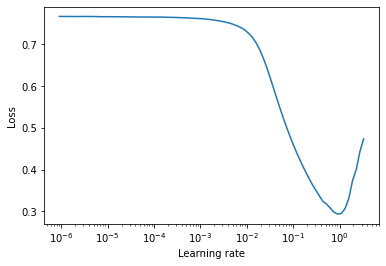

In [29]:
seed = 0
fold = 0 

seed_everything(seed)

train = process_data(folds)
test_ = process_data(test)

trn_idx = train[train['kfold'] != fold].index
val_idx = train[train['kfold'] == fold].index

train_df = train[train['kfold'] != fold].reset_index(drop=True)
valid_df = train[train['kfold'] == fold].reset_index(drop=True)

x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values

class MoADataset_:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return (dct['x'], dct['y'])#dct

train_dataset = MoADataset_(x_train, y_train)
valid_dataset = MoADataset_(x_valid, y_valid)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = Model(
    num_features=num_features,
    num_targets=num_targets,
    hidden_size=hidden_size,
)

#model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=WEIGHT_DECAY)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
#                                           max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))

criterion = nn.BCEWithLogitsLoss()

from torch_lr_finder import LRFinder

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [30]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=LEARNING_RATE, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [31]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [32]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3 ,4, 5]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

FOLD: 0, EPOCH: 0, train_loss: 0.6012294646082581
FOLD: 0, EPOCH: 0, valid_loss: 0.07284837748323168
FOLD: 0, EPOCH: 1, train_loss: 0.028350793689057446
FOLD: 0, EPOCH: 1, valid_loss: 0.02100266505564962
FOLD: 0, EPOCH: 2, train_loss: 0.021490097437323868
FOLD: 0, EPOCH: 2, valid_loss: 0.019112395867705346
FOLD: 0, EPOCH: 3, train_loss: 0.019468110169459513
FOLD: 0, EPOCH: 3, valid_loss: 0.018191179766186647
FOLD: 0, EPOCH: 4, train_loss: 0.01867784150754628
FOLD: 0, EPOCH: 4, valid_loss: 0.01795157425637756
FOLD: 0, EPOCH: 5, train_loss: 0.01829815324584859
FOLD: 0, EPOCH: 5, valid_loss: 0.01751391469900097
FOLD: 0, EPOCH: 6, train_loss: 0.01786791458995878
FOLD: 0, EPOCH: 6, valid_loss: 0.0175403876762305
FOLD: 0, EPOCH: 7, train_loss: 0.01780696579700579
FOLD: 0, EPOCH: 7, valid_loss: 0.01735452650380986
FOLD: 0, EPOCH: 8, train_loss: 0.017615147893303547
FOLD: 0, EPOCH: 8, valid_loss: 0.017215105811400074
FOLD: 0, EPOCH: 9, train_loss: 0.01754359377251155
FOLD: 0, EPOCH: 9, valid_l

FOLD: 2, EPOCH: 19, train_loss: 0.01698481539885203
FOLD: 2, EPOCH: 19, valid_loss: 0.01681796054222754
FOLD: 2, EPOCH: 20, train_loss: 0.016950430483489796
FOLD: 2, EPOCH: 20, valid_loss: 0.01662271198417459
FOLD: 2, EPOCH: 21, train_loss: 0.01675029751588253
FOLD: 2, EPOCH: 21, valid_loss: 0.01650572307407856
FOLD: 2, EPOCH: 22, train_loss: 0.016584014297341524
FOLD: 2, EPOCH: 22, valid_loss: 0.01642881203442812
FOLD: 2, EPOCH: 23, train_loss: 0.016340858849656324
FOLD: 2, EPOCH: 23, valid_loss: 0.016383345957313264
FOLD: 2, EPOCH: 24, train_loss: 0.016172836500935366
FOLD: 2, EPOCH: 24, valid_loss: 0.016209292278758117
FOLD: 2, EPOCH: 25, train_loss: 0.015971242328700813
FOLD: 2, EPOCH: 25, valid_loss: 0.016241162829101086
FOLD: 2, EPOCH: 26, train_loss: 0.01570350593090921
FOLD: 2, EPOCH: 26, valid_loss: 0.01604797387761729
FOLD: 2, EPOCH: 27, train_loss: 0.015535689330241386
FOLD: 2, EPOCH: 27, valid_loss: 0.01600923538208008
FOLD: 2, EPOCH: 28, train_loss: 0.015469107905105837
FO

FOLD: 0, EPOCH: 8, train_loss: 0.017379898847877117
FOLD: 0, EPOCH: 8, valid_loss: 0.017075920743601664
FOLD: 0, EPOCH: 9, train_loss: 0.017369987112402483
FOLD: 0, EPOCH: 9, valid_loss: 0.017024151315646514
FOLD: 0, EPOCH: 10, train_loss: 0.017362960499535868
FOLD: 0, EPOCH: 10, valid_loss: 0.01702987588942051
FOLD: 0, EPOCH: 11, train_loss: 0.01741488218523454
FOLD: 0, EPOCH: 11, valid_loss: 0.017280552216938565
FOLD: 0, EPOCH: 12, train_loss: 0.017409678541825735
FOLD: 0, EPOCH: 12, valid_loss: 0.01715456335140126
FOLD: 0, EPOCH: 13, train_loss: 0.017413402705088905
FOLD: 0, EPOCH: 13, valid_loss: 0.017101124354771204
FOLD: 0, EPOCH: 14, train_loss: 0.017363987633607525
FOLD: 0, EPOCH: 14, valid_loss: 0.016969448806984085
FOLD: 0, EPOCH: 15, train_loss: 0.017395802888263395
FOLD: 0, EPOCH: 15, valid_loss: 0.016993500957531587
FOLD: 0, EPOCH: 16, train_loss: 0.017320778355866238
FOLD: 0, EPOCH: 16, valid_loss: 0.016881593210356576
FOLD: 0, EPOCH: 17, train_loss: 0.01717910268411472
F

FOLD: 2, EPOCH: 27, train_loss: 0.01556611718420965
FOLD: 2, EPOCH: 27, valid_loss: 0.015939416284007687
FOLD: 2, EPOCH: 28, train_loss: 0.015393492914196373
FOLD: 2, EPOCH: 28, valid_loss: 0.015897422097623348
FOLD: 2, EPOCH: 29, train_loss: 0.015322213904743177
FOLD: 2, EPOCH: 29, valid_loss: 0.01593761518597603
FOLD: 3, EPOCH: 0, train_loss: 0.600451173449772
FOLD: 3, EPOCH: 0, valid_loss: 0.07252676912716456
FOLD: 3, EPOCH: 1, train_loss: 0.028246676238874596
FOLD: 3, EPOCH: 1, valid_loss: 0.020924615061708857
FOLD: 3, EPOCH: 2, train_loss: 0.020389156726499397
FOLD: 3, EPOCH: 2, valid_loss: 0.018805188685655595
FOLD: 3, EPOCH: 3, train_loss: 0.018870546981908272
FOLD: 3, EPOCH: 3, valid_loss: 0.018002211089645115
FOLD: 3, EPOCH: 4, train_loss: 0.018071314772132082
FOLD: 3, EPOCH: 4, valid_loss: 0.017725691944360734
FOLD: 3, EPOCH: 5, train_loss: 0.017779248800344656
FOLD: 3, EPOCH: 5, valid_loss: 0.017375574606869903
FOLD: 3, EPOCH: 6, train_loss: 0.01744932374930468
FOLD: 3, EPOC

FOLD: 0, EPOCH: 16, train_loss: 0.017194650264159925
FOLD: 0, EPOCH: 16, valid_loss: 0.01708337174994605
FOLD: 0, EPOCH: 17, train_loss: 0.017228408723367727
FOLD: 0, EPOCH: 17, valid_loss: 0.01693269128778151
FOLD: 0, EPOCH: 18, train_loss: 0.017097427260022665
FOLD: 0, EPOCH: 18, valid_loss: 0.016971422279519695
FOLD: 0, EPOCH: 19, train_loss: 0.017105198897205402
FOLD: 0, EPOCH: 19, valid_loss: 0.016693602608782904
FOLD: 0, EPOCH: 20, train_loss: 0.01686461998041773
FOLD: 0, EPOCH: 20, valid_loss: 0.016577125393918583
FOLD: 0, EPOCH: 21, train_loss: 0.016758854143267523
FOLD: 0, EPOCH: 21, valid_loss: 0.016634410353643554
FOLD: 0, EPOCH: 22, train_loss: 0.016548257604565308
FOLD: 0, EPOCH: 22, valid_loss: 0.016422888184232372
FOLD: 0, EPOCH: 23, train_loss: 0.016347141187314108
FOLD: 0, EPOCH: 23, valid_loss: 0.016343490460089274
FOLD: 0, EPOCH: 24, train_loss: 0.016087200965030468
FOLD: 0, EPOCH: 24, valid_loss: 0.016206095181405544
FOLD: 0, EPOCH: 25, train_loss: 0.015910070760688

FOLD: 3, EPOCH: 5, train_loss: 0.017634178410567667
FOLD: 3, EPOCH: 5, valid_loss: 0.01742887550166675
FOLD: 3, EPOCH: 6, train_loss: 0.017463133184482223
FOLD: 3, EPOCH: 6, valid_loss: 0.017327695659228735
FOLD: 3, EPOCH: 7, train_loss: 0.017432376344188833
FOLD: 3, EPOCH: 7, valid_loss: 0.017412867716380526
FOLD: 3, EPOCH: 8, train_loss: 0.01740516531213686
FOLD: 3, EPOCH: 8, valid_loss: 0.01731897917176996
FOLD: 3, EPOCH: 9, train_loss: 0.01727837114257441
FOLD: 3, EPOCH: 9, valid_loss: 0.017295954136976172
FOLD: 3, EPOCH: 10, train_loss: 0.017404154577440975
FOLD: 3, EPOCH: 10, valid_loss: 0.01726268998214177
FOLD: 3, EPOCH: 11, train_loss: 0.01736542003472214
FOLD: 3, EPOCH: 11, valid_loss: 0.0172422087884375
FOLD: 3, EPOCH: 12, train_loss: 0.017402951004982428
FOLD: 3, EPOCH: 12, valid_loss: 0.017342890932091643
FOLD: 3, EPOCH: 13, train_loss: 0.017377105845219416
FOLD: 3, EPOCH: 13, valid_loss: 0.017322623756315027
FOLD: 3, EPOCH: 14, train_loss: 0.017314591451777495
FOLD: 3, EP

FOLD: 0, EPOCH: 24, train_loss: 0.016090391554694244
FOLD: 0, EPOCH: 24, valid_loss: 0.016187411599925587
FOLD: 0, EPOCH: 25, train_loss: 0.01585920640280929
FOLD: 0, EPOCH: 25, valid_loss: 0.016106772289744446
FOLD: 0, EPOCH: 26, train_loss: 0.015601785448582275
FOLD: 0, EPOCH: 26, valid_loss: 0.01602414660155773
FOLD: 0, EPOCH: 27, train_loss: 0.015489266092038673
FOLD: 0, EPOCH: 27, valid_loss: 0.015994311017649514
FOLD: 0, EPOCH: 28, train_loss: 0.015342468071890913
FOLD: 0, EPOCH: 28, valid_loss: 0.01597602753234761
FOLD: 0, EPOCH: 29, train_loss: 0.015294621644568617
FOLD: 0, EPOCH: 29, valid_loss: 0.015967677852937154
FOLD: 1, EPOCH: 0, train_loss: 0.6012172058656595
FOLD: 1, EPOCH: 0, valid_loss: 0.07554061497960772
FOLD: 1, EPOCH: 1, train_loss: 0.02796580618166405
FOLD: 1, EPOCH: 1, valid_loss: 0.021167669658149993
FOLD: 1, EPOCH: 2, train_loss: 0.02052951556886884
FOLD: 1, EPOCH: 2, valid_loss: 0.01923384756914207
FOLD: 1, EPOCH: 3, train_loss: 0.01911231412457815
FOLD: 1, E

FOLD: 3, EPOCH: 13, train_loss: 0.017397134686293808
FOLD: 3, EPOCH: 13, valid_loss: 0.017174994439951012
FOLD: 3, EPOCH: 14, train_loss: 0.017378095591413803
FOLD: 3, EPOCH: 14, valid_loss: 0.017217218929103443
FOLD: 3, EPOCH: 15, train_loss: 0.017450381853226303
FOLD: 3, EPOCH: 15, valid_loss: 0.017217687224703175
FOLD: 3, EPOCH: 16, train_loss: 0.017381354903235384
FOLD: 3, EPOCH: 16, valid_loss: 0.017107104563287328
FOLD: 3, EPOCH: 17, train_loss: 0.01715434068624956
FOLD: 3, EPOCH: 17, valid_loss: 0.01711808168994529
FOLD: 3, EPOCH: 18, train_loss: 0.01706275167753515
FOLD: 3, EPOCH: 18, valid_loss: 0.01696129467870508
FOLD: 3, EPOCH: 19, train_loss: 0.016942480295572594
FOLD: 3, EPOCH: 19, valid_loss: 0.016833088972738813
FOLD: 3, EPOCH: 20, train_loss: 0.016809823781089937
FOLD: 3, EPOCH: 20, valid_loss: 0.016820520854422025
FOLD: 3, EPOCH: 21, train_loss: 0.01666515882032505
FOLD: 3, EPOCH: 21, valid_loss: 0.016695297669087138
FOLD: 3, EPOCH: 22, train_loss: 0.01650310350258065

FOLD: 1, EPOCH: 2, train_loss: 0.020294536768958187
FOLD: 1, EPOCH: 2, valid_loss: 0.01859721466898918
FOLD: 1, EPOCH: 3, train_loss: 0.018939230914997017
FOLD: 1, EPOCH: 3, valid_loss: 0.01771680215107543
FOLD: 1, EPOCH: 4, train_loss: 0.018102676209494257
FOLD: 1, EPOCH: 4, valid_loss: 0.018065163306891917
FOLD: 1, EPOCH: 5, train_loss: 0.017709309309451044
FOLD: 1, EPOCH: 5, valid_loss: 0.017238434004996504
FOLD: 1, EPOCH: 6, train_loss: 0.017461288936328197
FOLD: 1, EPOCH: 6, valid_loss: 0.0171205180564097
FOLD: 1, EPOCH: 7, train_loss: 0.01750698005375655
FOLD: 1, EPOCH: 7, valid_loss: 0.01711597094046218
FOLD: 1, EPOCH: 8, train_loss: 0.017480130314125097
FOLD: 1, EPOCH: 8, valid_loss: 0.017027201716388975
FOLD: 1, EPOCH: 9, train_loss: 0.017374562619227
FOLD: 1, EPOCH: 9, valid_loss: 0.017180185791637215
FOLD: 1, EPOCH: 10, train_loss: 0.01745529704308812
FOLD: 1, EPOCH: 10, valid_loss: 0.017147103058440343
FOLD: 1, EPOCH: 11, train_loss: 0.017395530233456604
FOLD: 1, EPOCH: 11,

FOLD: 3, EPOCH: 21, train_loss: 0.016659555545049734
FOLD: 3, EPOCH: 21, valid_loss: 0.016735379158386163
FOLD: 3, EPOCH: 22, train_loss: 0.016518404923271442
FOLD: 3, EPOCH: 22, valid_loss: 0.016599586472979613
FOLD: 3, EPOCH: 23, train_loss: 0.016269631515108587
FOLD: 3, EPOCH: 23, valid_loss: 0.016493061929941176
FOLD: 3, EPOCH: 24, train_loss: 0.016031953823361277
FOLD: 3, EPOCH: 24, valid_loss: 0.01635504394237484
FOLD: 3, EPOCH: 25, train_loss: 0.01576060638425575
FOLD: 3, EPOCH: 25, valid_loss: 0.016299985854753427
FOLD: 3, EPOCH: 26, train_loss: 0.015571494094109621
FOLD: 3, EPOCH: 26, valid_loss: 0.01624175464468343
FOLD: 3, EPOCH: 27, train_loss: 0.01540298632386586
FOLD: 3, EPOCH: 27, valid_loss: 0.016192706009106977
FOLD: 3, EPOCH: 28, train_loss: 0.01528355128982145
FOLD: 3, EPOCH: 28, valid_loss: 0.016190630197525025
FOLD: 3, EPOCH: 29, train_loss: 0.015174823630925106
FOLD: 3, EPOCH: 29, valid_loss: 0.016177300177514554
FOLD: 4, EPOCH: 0, train_loss: 0.6015157858314721
F

FOLD: 1, EPOCH: 10, train_loss: 0.017337541082415028
FOLD: 1, EPOCH: 10, valid_loss: 0.016992962972394058
FOLD: 1, EPOCH: 11, train_loss: 0.017346763733666445
FOLD: 1, EPOCH: 11, valid_loss: 0.01708397434226104
FOLD: 1, EPOCH: 12, train_loss: 0.01742828887063956
FOLD: 1, EPOCH: 12, valid_loss: 0.017182683146425657
FOLD: 1, EPOCH: 13, train_loss: 0.017452673959559288
FOLD: 1, EPOCH: 13, valid_loss: 0.017218911168830734
FOLD: 1, EPOCH: 14, train_loss: 0.017406015029258055
FOLD: 1, EPOCH: 14, valid_loss: 0.017019513196178844
FOLD: 1, EPOCH: 15, train_loss: 0.0173011333209233
FOLD: 1, EPOCH: 15, valid_loss: 0.01706404449152095
FOLD: 1, EPOCH: 16, train_loss: 0.017219754752527544
FOLD: 1, EPOCH: 16, valid_loss: 0.016915672751409667
FOLD: 1, EPOCH: 17, train_loss: 0.017226119788930468
FOLD: 1, EPOCH: 17, valid_loss: 0.01690302129302706
FOLD: 1, EPOCH: 18, train_loss: 0.01712973928079009
FOLD: 1, EPOCH: 18, valid_loss: 0.016692276698138032
FOLD: 1, EPOCH: 19, train_loss: 0.016927063822800268


FOLD: 3, EPOCH: 29, train_loss: 0.015131510490470606
FOLD: 3, EPOCH: 29, valid_loss: 0.016157992157552925
FOLD: 4, EPOCH: 0, train_loss: 0.6011913240063882
FOLD: 4, EPOCH: 0, valid_loss: 0.06963097878864834
FOLD: 4, EPOCH: 1, train_loss: 0.027935690961886143
FOLD: 4, EPOCH: 1, valid_loss: 0.020257895652736935
FOLD: 4, EPOCH: 2, train_loss: 0.020358053332977535
FOLD: 4, EPOCH: 2, valid_loss: 0.018684232607483864
FOLD: 4, EPOCH: 3, train_loss: 0.019055977969875803
FOLD: 4, EPOCH: 3, valid_loss: 0.01796668576342719
FOLD: 4, EPOCH: 4, train_loss: 0.018099716810536556
FOLD: 4, EPOCH: 4, valid_loss: 0.017527896431939943
FOLD: 4, EPOCH: 5, train_loss: 0.017683016628944788
FOLD: 4, EPOCH: 5, valid_loss: 0.017223992331751755
FOLD: 4, EPOCH: 6, train_loss: 0.017526558316920116
FOLD: 4, EPOCH: 6, valid_loss: 0.017128692593957696
FOLD: 4, EPOCH: 7, train_loss: 0.017433119613839233
FOLD: 4, EPOCH: 7, valid_loss: 0.017125361120062216
FOLD: 4, EPOCH: 8, train_loss: 0.017452500288145267
FOLD: 4, EPOCH

In [33]:
train_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
len(target_cols)

206

In [35]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)

CV log_loss:  0.014648880292108497


In [36]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)